In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)


In [3]:
import re
rent_list = []
house = pd.read_csv("../data/prepared_data.csv")
house = house.drop_duplicates(subset=None, keep='first', inplace=False)
price_df = house[['price','rent']]
for index, values in price_df.iterrows():
    if pd.isna(values['rent']) or values['rent'] == 0:
        rent = re.findall(r'\d*[.]?\d+',values['price'])
        if len(rent) >= 1:
            house.loc[index,'rent'] = float(rent[0])
        else:
            house = house.drop(index = index)

            

In [4]:
house_df = house[house['rent'] > 0].reset_index()
median_price = house_df.groupby(['bathrooms', 'bedrooms', 'carspaces','year','postcode'],as_index = False)['rent'].median('rent')
median_rent = dict()
for index, values in median_price.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    median_rent[key] = values['rent']
values_list = []
for item,values in house_df.iterrows():
    year = values['year']
    bathrooms = values['bathrooms']
    bedrooms = values['bedrooms']
    carspaces = values['carspaces']
    postcode = values['postcode']
    key = postcode+year+bathrooms+bedrooms+carspaces
    hit = median_rent[key]
    values_list.append(hit)
house_df['median_rent'] = values_list 
house_df = house_df[house_df['rent'] <  3 * house_df['median_rent']]
house_df = house_df[house_df['rent'] >  0.15 * house_df['median_rent']]

In [1130]:
house_df[house_df['postcode'] == 3842]['rent'].min()

200.0

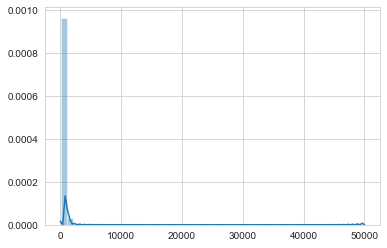

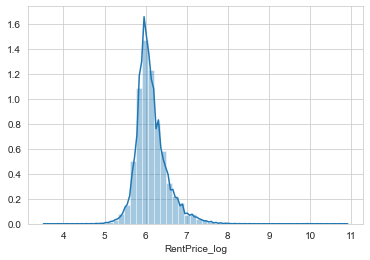

In [5]:
## check if we need to log the rental price as the price might be skewed
import seaborn as sns 
import matplotlib 
import matplotlib.pyplot as plt

x = list(house_df['rent'])
sns.set_style('whitegrid')
sns.distplot(x)
plt.show()

house_df['RentPrice_log'] = np.log(house_df["rent"])
x = house_df['RentPrice_log']
sns.distplot(x)
plt.show()

In [6]:
newdf = house_df.drop(['level_0','Unnamed: 0','price','geometry', 'geoLocation','index_right','SA2_maincode_2021','median_rent'], axis=1)
def bond(val):
    if pd.isna(val) or val == 0:
        return 0
    return 1
newdf['has_bond'] = newdf['bond'].apply(bond)
newdf = newdf.drop(['bond'], axis=1)

In [7]:
newdf = newdf.drop(['dateUpdated','dateListed'], axis=1)
newdf = newdf.drop(['sum','mean'],axis = 1)
newdf = newdf.drop(['Earners'],axis = 1)
newdf = newdf.drop(['landAreaSqm'],axis = 1)
newdf = newdf.drop('population_increase',axis = 1)
newdf = newdf.drop(['propertyTypes'], axis=1)

In [1345]:
list(newdf.columns)[11:26]

['fast_food',
 'kindergarten',
 'parking',
 'restaurant',
 'place_of_worship',
 'school',
 'university',
 'garden',
 'park',
 'playground',
 'pitch',
 'bus_count',
 'bus_distance',
 'school_count',
 'school_distance']

In [8]:
newdf = newdf[newdf['bus_distance'] > 0]
for col in list(newdf.columns)[11:26]:
    newdf[col] = newdf[col].fillna(0)

In [9]:
for index, values in newdf[pd.isna(newdf['median'])].iterrows():
    income_median = newdf['median'].median()
    newdf.loc[index,'median'] = income_median
for index, values in newdf[pd.isna(newdf['Median_age'])].iterrows():
    Median_age = newdf['Median_age'].median()
    newdf.loc[index,'Median_age'] = Median_age

In [10]:
newdf = newdf[newdf['population'] > 0]
newdf = newdf.drop(['index','longitude', 'latitude'],axis = 1)
# newdf = newdf.drop('surburb', axis=1)
newdf.columns

Index(['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'surburb', 'year',
       'month', 'rent', 'bench', 'cafe', 'childcare', 'fast_food',
       'kindergarten', 'parking', 'restaurant', 'place_of_worship', 'school',
       'university', 'garden', 'park', 'playground', 'pitch', 'bus_count',
       'bus_distance', 'school_count', 'school_distance', 'tram_distance',
       'tram_count', 'train_distance', 'train_count', 'hospital_count',
       'shopping_mall_distance', 'shopping_mall_count', 'offence count',
       'incidents recorded', 'Median_age', 'median', 'population',
       'RentPrice_log', 'has_bond'],
      dtype='object')

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
y = newdf['RentPrice_log']
X = newdf.drop(['RentPrice_log','rent','year','month','surburb'], axis=1)
selector = SelectKBest(f_regression, k = 28)
selector.fit(X, y)
needcolf = X.columns[selector.get_support()]
needcolf

Index(['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'bench', 'cafe',
       'childcare', 'fast_food', 'restaurant', 'school', 'university', 'park',
       'playground', 'pitch', 'bus_count', 'school_count', 'tram_distance',
       'tram_count', 'train_distance', 'train_count', 'hospital_count',
       'shopping_mall_distance', 'shopping_mall_count', 'offence count',
       'incidents recorded', 'Median_age', 'median', 'has_bond'],
      dtype='object')

In [13]:
needcolf = list(needcolf)
needcolf.append('year')
needcolf.append('month')
needcolf

['bathrooms',
 'bedrooms',
 'carspaces',
 'postcode',
 'bench',
 'cafe',
 'childcare',
 'fast_food',
 'restaurant',
 'school',
 'university',
 'park',
 'playground',
 'pitch',
 'bus_count',
 'school_count',
 'tram_distance',
 'tram_count',
 'train_distance',
 'train_count',
 'hospital_count',
 'shopping_mall_distance',
 'shopping_mall_count',
 'offence count',
 'incidents recorded',
 'Median_age',
 'median',
 'has_bond',
 'year',
 'month']

In [14]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
selector = SelectKBest(mutual_info_regression, k = 28)
selector.fit(X, y)
needcomi = X.columns[selector.get_support()]

In [15]:
needcomi = list(needcomi)
needcomi.append('year')
needcomi.append('month')
needcomi

['bathrooms',
 'bedrooms',
 'carspaces',
 'postcode',
 'bench',
 'cafe',
 'fast_food',
 'parking',
 'restaurant',
 'place_of_worship',
 'school',
 'garden',
 'park',
 'playground',
 'pitch',
 'bus_count',
 'bus_distance',
 'school_count',
 'school_distance',
 'tram_distance',
 'tram_count',
 'train_distance',
 'shopping_mall_distance',
 'offence count',
 'incidents recorded',
 'Median_age',
 'median',
 'population',
 'year',
 'month']

In [16]:
house_count = pd.DataFrame(newdf['postcode'].value_counts()).reset_index().rename({"index":"postcode",'postcode':'count'},axis = 1)
house_count

,postcode,count
0,3000,9258
1,3029,2886
2,3006,2822
3,3141,2574
4,3008,2550
...,...,...
374,3509,1
375,3379,1
376,3377,1
377,3823,1


In [18]:
newdf['Median_age'] = newdf['Median_age'].apply(lambda x:round(x))
newdf['population'] = newdf['population'].apply(lambda x:round(x))

In [19]:
newdf

,bathrooms,bedrooms,carspaces,postcode,surburb,year,month,rent,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,Median_age,median,population,RentPrice_log,has_bond
0,1.0,1.0,0.0,3205,south melbourne,2019,1,360.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,38,66259.675774,12753,5.886104,0
1,2.0,2.0,1.0,3205,south melbourne,2019,1,725.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,38,66259.675774,12753,6.586172,0
2,1.0,2.0,0.0,3205,south melbourne,2019,1,500.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,38,66259.675774,12753,6.214608,0
3,1.0,3.0,0.0,3205,south melbourne,2019,1,795.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,38,66259.675774,12753,6.678342,0
4,2.0,2.0,0.0,3205,south melbourne,2019,1,825.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,38,66259.675774,12753,6.715383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105918,1.0,3.0,1.0,3701,dartmouth,2022,5,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,48,44583.025987,6181,5.634790,0
105919,1.0,3.0,1.0,3701,dartmouth,2022,6,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230,48,44583.025987,6181,5.669881,0
105920,1.0,3.0,2.0,3700,tallangatta,2022,8,470.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7.265,3,7.593,253.141,0,240.828,0,1,32.738,0,605,484,37,55477.266641,6181,6.152733,0
105921,1.0,3.0,2.0,3700,tallangatta,2021,3,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.234,3,0.271,248.167,0,236.377,0,1,25.565,0,605,484,37,55477.266641,6153,5.736572,0


In [20]:
group_dict = dict()
for index, values in newdf.iterrows():
    bathroom = str(values['bathrooms'])
    bedroom = str(values['bedrooms'])
    carspaces = str(values['carspaces'])
    postcodes = str(values['postcode'])
    year = str(values['year'])
    month = str(values['month'])
    key = bathroom +' ' + bedroom+' ' + carspaces +' ' +postcodes+' ' +year+' ' + month
    group_list = group_dict.get(key,[])
    group_list.append(values)
    group_dict[key] = group_list

In [21]:
predict_dict = dict()
for index, values in newdf.iterrows():
    bathroom = str(values['bathrooms'])
    bedroom = str(values['bedrooms'])
    carspaces = str(values['carspaces'])
    postcodes = str(values['postcode'])
    key = bathroom+' ' + bedroom+' ' +carspaces+' ' +postcodes
    predict_list = predict_dict.get(key,[])
    predict_list.append(values)
    predict_dict[key] = predict_list


In [22]:
data_list = []
for key, values in group_dict.items():
    rent_price_sum = 0
    bus_distance_sum = 0
    tram_distance_sum = 0
    train_distance_sum = 0
    shopping_mall_distance_sum = 0
    school_distance_sum = 0
    num = len(values)
    for item in values:
        rent_price_sum += item['RentPrice_log']
        bus_distance_sum += item['bus_distance']
        train_distance_sum += item['train_distance']
        tram_distance_sum += item['tram_distance']
        shopping_mall_distance_sum += item['shopping_mall_distance']
        school_distance_sum += item['school_distance']
    rent_mean = rent_price_sum/num
    bus_mean = bus_distance_sum/num
    train_mean = train_distance_sum/num
    tram_mean = tram_distance_sum/num
    shopping_mall_mean = shopping_mall_distance_sum/num
    school_mean = school_distance_sum/num
    data_list.append([item['bathrooms'],item['bedrooms'],item['carspaces'],item['postcode'],item['year'],item['month'],train_mean,item['train_count'],
    item['hospital_count'],shopping_mall_mean,item['shopping_mall_count'],item['bench'],item['cafe'],item['childcare'],item['fast_food'],item['kindergarten'],item['parking'],item['restaurant']
    ,item['place_of_worship'],item['school'],school_mean,item['university'], item['garden'], item['park'],item['playground'], item['pitch'], item['offence count'], item['incidents recorded'],bus_mean,item['bus_count'],item['school_count'],tram_mean,
    item['tram_count'],rent_mean,item['Median_age'],item['median'],item['population'],item['has_bond']])
    # data_list.append((item['bathrooms'],item['bedrooms'],item['carspaces'],item['postcode'],item['year'],item['month'],rent_mean,bus_mean,train_mean,tram_mean,shopping_mall_mean))



In [23]:
data_list_2 = []
for key, values in predict_dict.items():
    rent_price_sum = 0
    bus_distance_sum = 0
    tram_distance_sum = 0
    train_distance_sum = 0
    shopping_mall_distance_sum = 0
    num = len(values)
    for item in values:
        rent_price_sum += item['RentPrice_log']
        bus_distance_sum += item['bus_distance']
        train_distance_sum += item['train_distance']
        tram_distance_sum += item['tram_distance']
        shopping_mall_distance_sum += item['shopping_mall_distance']
    rent_mean = rent_price_sum/num
    bus_mean = bus_distance_sum/num
    train_mean = train_distance_sum/num
    tram_mean = tram_distance_sum/num
    shopping_mall_mean = shopping_mall_distance_sum/num
    data_list_2.append([item['bathrooms'],item['bedrooms'],item['carspaces'],item['postcode'],train_mean,item['train_count'],
    item['hospital_count'],shopping_mall_mean,item['shopping_mall_count'],item['bench'],item['cafe'],item['childcare'],item['fast_food'],item['kindergarten'],item['parking'],item['restaurant']
    ,item['place_of_worship'],item['school'],item['university'], item['garden'], item['park'],item['playground'], item['pitch'], item['offence count'], item['incidents recorded'],bus_mean,item['bus_count'],item['school_count'],tram_mean,
    item['tram_count'],rent_mean,item['Median_age'],item['median'],item['population'],item['has_bond']])

In [24]:
df = pd.DataFrame(data_list, columns=['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'year',
       'month', 'train_distance', 'train_count',
       'hospital_count', 'shopping_mall_distance', 'shopping_mall_count',
       'bench', 'cafe', 'childcare', 'fast_food', 'kindergarten', 'parking',
       'restaurant', 'place_of_worship', 'school', 'school_distance','university', 'garden',
       'park', 'playground', 'pitch', 'offence count','incidents recorded', 'bus_distance',
       'bus_count', 'school_count', 'tram_distance', 'tram_count', 'rent',
       'Median_age', 'median', 'population', 'has_bond'])
df

,bathrooms,bedrooms,carspaces,postcode,year,month,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,school_distance,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,tram_distance,tram_count,rent,Median_age,median,population,has_bond
0,1.0,1.0,0.0,3205,2019,1,2.677111,0,0,1.341556,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.467667,0.0,8.0,16.0,10.0,5.0,22895,17201,0.504111,10,3,0.124444,24,5.870629,38,66259.675774,1281,0
1,2.0,2.0,1.0,3205,2019,1,2.374714,0,0,1.422286,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.306429,0.0,8.0,16.0,10.0,5.0,22895,17201,0.730429,10,3,0.162143,24,6.406003,38,66259.675774,1281,1
2,1.0,2.0,0.0,3205,2019,1,2.863250,0,0,1.663750,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.361250,0.0,8.0,16.0,10.0,5.0,22895,17201,0.570250,10,3,0.151750,24,6.407817,38,66259.675774,12753,0
3,1.0,3.0,0.0,3205,2019,1,3.122500,0,0,1.413500,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.344500,0.0,8.0,16.0,10.0,5.0,22895,17201,0.318500,10,3,0.112500,24,6.711789,38,66259.675774,12753,0
4,2.0,2.0,0.0,3205,2019,1,3.534400,0,0,1.388800,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.408600,0.0,8.0,16.0,10.0,5.0,22895,17201,0.137800,10,3,0.334000,24,6.712508,38,66259.675774,12753,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45176,1.0,3.0,1.0,3701,2022,5,233.799000,0,0,68.639000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.219000,0.0,0.0,0.0,0.0,0.0,302,230,52.649000,1,2,249.694000,0,5.634790,48,44583.025987,6181,0
45177,1.0,3.0,1.0,3701,2022,6,233.877000,0,0,68.662000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.283000,0.0,0.0,0.0,0.0,0.0,302,230,52.627000,1,2,249.772000,0,5.669881,48,44583.025987,6181,0
45178,1.0,3.0,2.0,3700,2022,8,240.828000,0,1,32.738000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.593000,0.0,0.0,0.0,0.0,0.0,605,484,7.265000,1,3,253.141000,0,6.152733,37,55477.266641,6181,0
45179,1.0,3.0,2.0,3700,2021,3,236.377000,0,1,25.565000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.271000,0.0,0.0,0.0,0.0,0.0,605,484,0.234000,1,3,248.167000,0,5.736572,37,55477.266641,6153,0


In [25]:
df2 = pd.DataFrame(data_list_2, columns=['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'train_distance', 'train_count',
       'hospital_count', 'shopping_mall_distance', 'shopping_mall_count',
       'bench', 'cafe', 'childcare', 'fast_food', 'kindergarten', 'parking',
       'restaurant', 'place_of_worship', 'school', 'university', 'garden',
       'park', 'playground', 'pitch', 'offence count','incidents recorded', 'bus_distance',
       'bus_count', 'school_count', 'tram_distance', 'tram_count', 'rent',
       'Median_age', 'median', 'population', 'has_bond'])
df2

,bathrooms,bedrooms,carspaces,postcode,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,tram_distance,tram_count,rent,Median_age,median,population,has_bond
0,1.0,1.0,0.0,3205,2.372479,0,0,1.530774,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.791281,10,3,0.133295,24,5.873056,38,68466.042203,1942,1
1,2.0,2.0,1.0,3205,2.411860,0,0,1.486444,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.738357,10,3,0.183377,24,6.379859,39,69810.297518,6528,0
2,1.0,2.0,0.0,3205,2.921702,0,0,1.482578,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.440760,10,3,0.208787,24,6.361757,38,67037.994227,1705,0
3,1.0,3.0,0.0,3205,3.144525,0,0,1.418525,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.290175,10,3,0.215850,24,6.570844,38,66259.675774,12753,1
4,2.0,2.0,0.0,3205,3.165820,0,0,1.422120,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.337940,10,3,0.290900,24,6.580744,38,67037.994227,1705,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7630,1.0,3.0,1.0,3701,233.838000,0,0,68.650500,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302,230,52.638000,1,2,249.733000,0,5.632478,48,44583.025987,6181,0
7631,1.0,3.0,3.0,3700,236.495000,0,1,25.418000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,0.475000,1,3,248.264000,0,5.857933,37,55477.266641,6153,0
7632,1.0,3.0,1.0,3700,236.068000,0,1,25.575000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,0.171000,1,3,247.873000,0,5.799093,37,55477.266641,6153,0
7633,1.0,3.0,2.0,3700,237.926667,0,1,28.007000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,2.618667,1,3,249.893333,0,5.915746,37,55477.266641,6153,0


In [26]:
df_combined = df.merge(house_count, on = 'postcode', how = 'left').fillna(0)
cpi_df = pd.read_csv('../data/cpi.csv').drop({'Unnamed: 0'}, axis = 1)
df_combined = df_combined.merge(cpi_df, on = 'year')
df_combined

,bathrooms,bedrooms,carspaces,postcode,year,month,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,school_distance,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,tram_distance,tram_count,rent,Median_age,median,population,has_bond,count,cpi
0,1.0,1.0,0.0,3205,2019,1,2.677111,0,0,1.341556,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.467667,0.0,8.0,16.0,10.0,5.0,22895,17201,0.504111,10,3,0.124444,24,5.870629,38,66259.675774,1281,0,1564,255.65
1,2.0,2.0,1.0,3205,2019,1,2.374714,0,0,1.422286,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.306429,0.0,8.0,16.0,10.0,5.0,22895,17201,0.730429,10,3,0.162143,24,6.406003,38,66259.675774,1281,1,1564,255.65
2,1.0,2.0,0.0,3205,2019,1,2.863250,0,0,1.663750,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.361250,0.0,8.0,16.0,10.0,5.0,22895,17201,0.570250,10,3,0.151750,24,6.407817,38,66259.675774,12753,0,1564,255.65
3,1.0,3.0,0.0,3205,2019,1,3.122500,0,0,1.413500,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.344500,0.0,8.0,16.0,10.0,5.0,22895,17201,0.318500,10,3,0.112500,24,6.711789,38,66259.675774,12753,0,1564,255.65
4,2.0,2.0,0.0,3205,2019,1,3.534400,0,0,1.388800,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.408600,0.0,8.0,16.0,10.0,5.0,22895,17201,0.137800,10,3,0.334000,24,6.712508,38,66259.675774,12753,0,1564,255.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45176,1.0,1.0,4.0,3460,2022,8,58.745000,0,1,35.093000,0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.896000,0.0,0.0,0.0,1.0,1.0,1879,1553,0.705000,2,3,78.624000,0,6.163315,52,47811.172529,10028,0,76,271.06
45177,1.0,2.0,0.0,3396,2022,9,294.648000,0,1,110.839000,0,0.0,3.0,0.0,1.0,0.0,4.0,0.0,1.0,3.0,0.477000,0.0,0.0,5.0,1.0,8.0,268,188,0.186000,1,2,315.390000,0,5.192957,37,55477.266641,6407,0,3,271.06
45178,1.0,3.0,1.0,3701,2022,5,233.799000,0,0,68.639000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.219000,0.0,0.0,0.0,0.0,0.0,302,230,52.649000,1,2,249.694000,0,5.634790,48,44583.025987,6181,0,5,271.06
45179,1.0,3.0,1.0,3701,2022,6,233.877000,0,0,68.662000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.283000,0.0,0.0,0.0,0.0,0.0,302,230,52.627000,1,2,249.772000,0,5.669881,48,44583.025987,6181,0,5,271.06


In [27]:
xls = pd.ExcelFile('../data/gdp.xlsx')
df1 = pd.read_excel(xls, 'Data')[36:].drop('Unnamed: 0', axis = 1).rename({'Unnamed: 1':'year','Unnamed: 2':'gdp'},axis = 1).reset_index().drop('index',axis = 1)
gdp_list = list(df1['gdp'])
l = []
m = 0
for i in range(2019,2026):
    l.append([i,gdp_list[m]])
    m = m+1
gdp_df = pd.DataFrame(l, columns=['year','gdp'])
gdp_df

,year,gdp
0,2019,54254.86
1,2020,52847.68
2,2021,63529.29
3,2022,67464.39
4,2023,69717.12
5,2024,72187.63
6,2025,74353.74


In [28]:
df_combined = df_combined.merge(gdp_df, on = 'year')

In [29]:
df_combined[needcolf]

,bathrooms,bedrooms,carspaces,postcode,bench,cafe,childcare,fast_food,restaurant,school,university,park,playground,pitch,bus_count,school_count,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,Median_age,median,has_bond,year,month
0,1.0,1.0,0.0,3205,11.0,41.0,4.0,17.0,40.0,1.0,0.0,16.0,10.0,5.0,10,3,0.124444,24,2.677111,0,0,1.341556,0,22895,17201,38,66259.675774,0,2019,1
1,2.0,2.0,1.0,3205,11.0,41.0,4.0,17.0,40.0,1.0,0.0,16.0,10.0,5.0,10,3,0.162143,24,2.374714,0,0,1.422286,0,22895,17201,38,66259.675774,1,2019,1
2,1.0,2.0,0.0,3205,11.0,41.0,4.0,17.0,40.0,1.0,0.0,16.0,10.0,5.0,10,3,0.151750,24,2.863250,0,0,1.663750,0,22895,17201,38,66259.675774,0,2019,1
3,1.0,3.0,0.0,3205,11.0,41.0,4.0,17.0,40.0,1.0,0.0,16.0,10.0,5.0,10,3,0.112500,24,3.122500,0,0,1.413500,0,22895,17201,38,66259.675774,0,2019,1
4,2.0,2.0,0.0,3205,11.0,41.0,4.0,17.0,40.0,1.0,0.0,16.0,10.0,5.0,10,3,0.334000,24,3.534400,0,0,1.388800,0,22895,17201,38,66259.675774,0,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45176,1.0,1.0,4.0,3460,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,2,3,78.624000,0,58.745000,0,1,35.093000,0,1879,1553,52,47811.172529,0,2022,8
45177,1.0,2.0,0.0,3396,0.0,3.0,0.0,1.0,0.0,3.0,0.0,5.0,1.0,8.0,1,2,315.390000,0,294.648000,0,1,110.839000,0,268,188,37,55477.266641,0,2022,9
45178,1.0,3.0,1.0,3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,249.694000,0,233.799000,0,0,68.639000,0,302,230,48,44583.025987,0,2022,5
45179,1.0,3.0,1.0,3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,249.772000,0,233.877000,0,0,68.662000,0,302,230,48,44583.025987,0,2022,6


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import json
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
y = df_combined['rent']
X = df_combined[needcolf]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
nn = MLPRegressor()
nn.fit(X_train_std, y_train)
TrainScore = nn.score(X_train_std, y_train)
TestScore = nn.score(X_test_std, y_test)
TestScore

0.7582405096840599

In [31]:
len(y_test)

13555

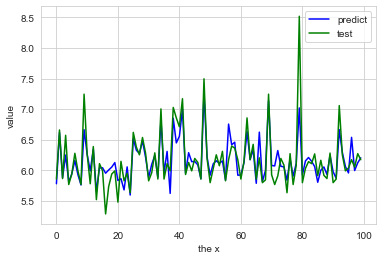

In [32]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 100)
y_predict = nn.predict(X_test_std)
y_p_sample = []
y_t_sample = []
for index in sample_index:
    y_p_sample.append(y_predict[index])
    y_t_sample.append(list(y_test)[index])
import matplotlib.pyplot as plt
y_predict = nn.predict(X_test_std)
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()


In [35]:
y = df_combined['rent']
X = df_combined[needcolf]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
rfc = RandomForestRegressor(max_depth=10)  
rfc = rfc.fit(X_train_std, y_train)
print(f'model score on training data: {rfc.score(X_train_std, y_train)}')
print(f'model score on testing data: {rfc.score(X_test_std, y_test)}')

model score on training data: 0.8532024131761508
model score on testing data: 0.7468012539068019


In [1342]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [1343]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_std, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  13.9s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  14.1s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=  14.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  35.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  35.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  36.1s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200

/Users/heyonglin/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  47.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  29.8s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  30.7s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=600; total time=  28.6s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=  45.2s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  56.0s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  55.9s
[CV] END bootstrap=True, max_depth=70

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [1347]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

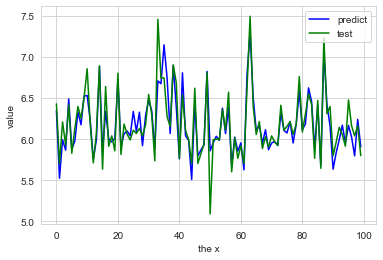

In [37]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 100)
y_predict = nn.predict(X_test_std)
y_p_sample = []
y_t_sample = []
for index in sample_index:
    y_p_sample.append(y_predict[index])
    y_t_sample.append(list(y_test)[index])
import matplotlib.pyplot as plt
y_predict = rfc.predict(X_test_std)
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()

In [910]:
# from sklearn.metrics import explained_variance_score, \
#     mean_absolute_error, \
#     mean_squared_error, \
#     median_absolute_error, r2_score

# print('数据线性回归模型测试集的平均绝对误差为：',mean_absolute_error(y_test, y_predict))
# print('数据线性回归模型测试集的均方误差为：',mean_squared_error(y_test, y_predict))
# print('数据线性回归模型测试集的中值绝对误差为：',median_absolute_error(y_test, y_predict))
# print('数据线性回归模型测试集的可解释方差值为：',explained_variance_score(y_test, y_predict))
# print('数据线性回归模型测试集的R方值为：',r2_score(y_test, y_predict))

数据线性回归模型测试集的平均绝对误差为： 0.42816158560668005
数据线性回归模型测试集的均方误差为： 0.3666577360922252
数据线性回归模型测试集的中值绝对误差为： 0.3105424467967328
数据线性回归模型测试集的可解释方差值为： -0.7370469971787066
数据线性回归模型测试集的R方值为： -0.7370486581100084


In [38]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(rfc, random_state=1).fit(X_test_std, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5294 ± 0.0169,tram_distance
0.4093 ± 0.0198,bedrooms
0.2960 ± 0.0073,bathrooms
0.1053 ± 0.0025,bus_count
0.0777 ± 0.0089,postcode
0.0438 ± 0.0043,median
0.0404 ± 0.0101,train_distance
0.0251 ± 0.0100,year
0.0238 ± 0.0177,shopping_mall_distance
0.0155 ± 0.0020,carspaces


In [ ]:
# r = permutation_importance(rfc, X_train_std, y_train, n_repeats = 5, random_state = 0)
# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{df_combined.columns[i]:<8}"
#         f"{r.importances_mean[i]:.3f}"
#         f" +/- {r.importances_std[i]:.3f}")

<Axes:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

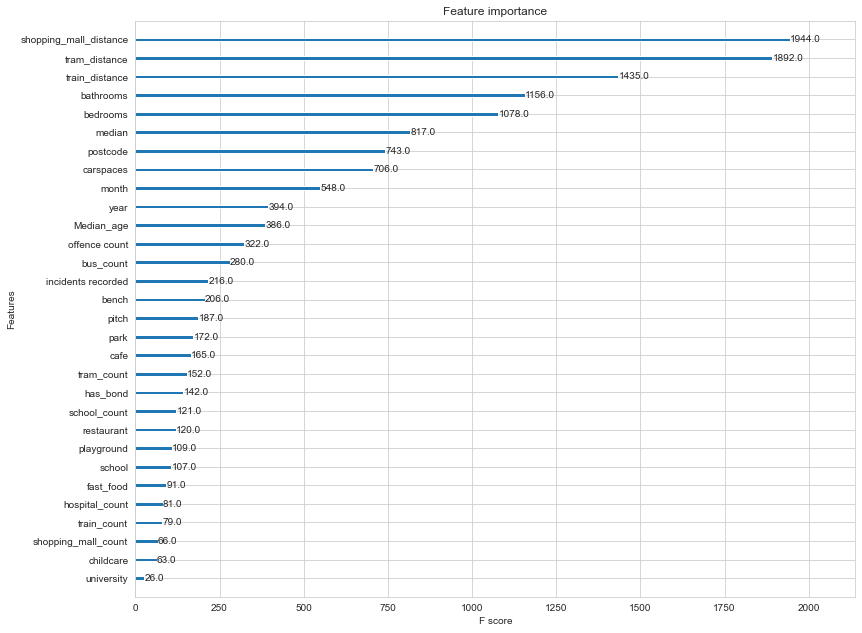

In [39]:
y = df_combined['rent']
X = df_combined[needcolf]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
xgbc = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 1000,
    max_depth = 4,
)
xgbc.fit(
    X_train, 
    y_train
)
fea_imp = xgbc.feature_importances_
fig = plt.figure(figsize = (10, 8))
ax = fig.add_axes([0,0,1,1])
xgb.plot_importance(xgbc, ax)

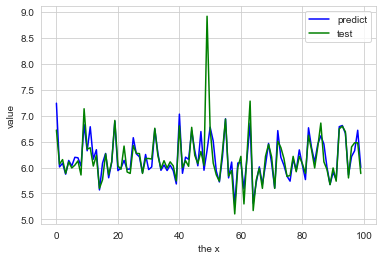

In [40]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 100)
y_predict = nn.predict(X_test_std)
y_p_sample = []
y_t_sample = []
for index in sample_index:
    y_p_sample.append(y_predict[index])
    y_t_sample.append(list(y_test)[index])
import matplotlib.pyplot as plt
y_predict = xgbc.predict(X_test)
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()


In [41]:
xgbc.score(X_test, y_test)

0.7917449105064882

In [42]:
from sklearn.tree import DecisionTreeRegressor
y = df_combined['rent']
X = df_combined[needcolf]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
dt = DecisionTreeRegressor()
dt.fit(X_train_std, y_train)
score = dt.score(X_test_std, y_test)
score

0.6191697027171317

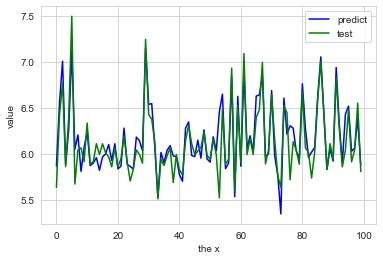

In [43]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 100)
y_predict = nn.predict(X_test_std)
y_p_sample = []
y_t_sample = []
for index in sample_index:
    y_p_sample.append(y_predict[index])
    y_t_sample.append(list(y_test)[index])
import matplotlib.pyplot as plt
y_predict = dt.predict(X_test_std)
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()

In [44]:
from sklearn.linear_model import LinearRegression
y = df_combined['rent']
X = df_combined[needcolf]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
lr = LinearRegression()
lr.fit(X_train_std, y_train)
score = lr.score(X_test_std, y_test)
score


0.5005252902183028

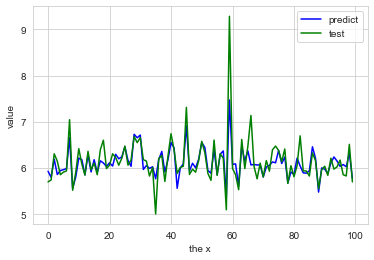

In [45]:
index = range(1,13555)
sample_index = np.random.choice(index, size = 100)
y_predict = nn.predict(X_test_std)
y_p_sample = []
y_t_sample = []
for index in sample_index:
    y_p_sample.append(y_predict[index])
    y_t_sample.append(list(y_test)[index])
import matplotlib.pyplot as plt
y_predict = lr.predict(X_test_std)
plt.plot(range(len(y_p_sample)), y_p_sample, 'b', label="predict")
plt.plot(range(len(y_t_sample)), y_t_sample, 'g', label="test")
plt.legend(loc="upper right")  
plt.xlabel("the x")
plt.ylabel('value')
plt.show()

In [1251]:
df2.columns

Index(['bathrooms', 'bedrooms', 'carspaces', 'postcode', 'train_distance',
       'train_count', 'hospital_count', 'shopping_mall_distance',
       'shopping_mall_count', 'bench', 'cafe', 'childcare', 'fast_food',
       'kindergarten', 'parking', 'restaurant', 'place_of_worship', 'school',
       'university', 'garden', 'park', 'playground', 'pitch', 'offence count',
       'incidents recorded', 'bus_distance', 'bus_count', 'school_count',
       'tram_distance', 'tram_count', 'rent', 'Median_age', 'median',
       'population', 'has_bond'],
      dtype='object')

In [46]:
df3 = pd.DataFrame()
for year in range(2023,2026):
    for month in range(1,13):
        tmp_df = df2.copy()
        year_list = [year]*len(df2)
        month_list = [month]*len(df2)
        tmp_df['year'] = year_list
        tmp_df['month'] = month_list
        df3= pd.concat([df3,tmp_df])
df3 = df3.reset_index().drop(['index'],axis = 1)
df3

,bathrooms,bedrooms,carspaces,postcode,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,tram_distance,tram_count,rent,Median_age,median,population,has_bond,year,month
0,1.0,1.0,0.0,3205,2.372479,0,0,1.530774,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.791281,10,3,0.133295,24,5.873056,38,68466.042203,1942,1,2023,1
1,2.0,2.0,1.0,3205,2.411860,0,0,1.486444,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.738357,10,3,0.183377,24,6.379859,39,69810.297518,6528,0,2023,1
2,1.0,2.0,0.0,3205,2.921702,0,0,1.482578,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.440760,10,3,0.208787,24,6.361757,38,67037.994227,1705,0,2023,1
3,1.0,3.0,0.0,3205,3.144525,0,0,1.418525,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.290175,10,3,0.215850,24,6.570844,38,66259.675774,12753,1,2023,1
4,2.0,2.0,0.0,3205,3.165820,0,0,1.422120,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.337940,10,3,0.290900,24,6.580744,38,67037.994227,1705,1,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274855,1.0,3.0,1.0,3701,233.838000,0,0,68.650500,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302,230,52.638000,1,2,249.733000,0,5.632478,48,44583.025987,6181,0,2025,12
274856,1.0,3.0,3.0,3700,236.495000,0,1,25.418000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,0.475000,1,3,248.264000,0,5.857933,37,55477.266641,6153,0,2025,12
274857,1.0,3.0,1.0,3700,236.068000,0,1,25.575000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,0.171000,1,3,247.873000,0,5.799093,37,55477.266641,6153,0,2025,12
274858,1.0,3.0,2.0,3700,237.926667,0,1,28.007000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,2.618667,1,3,249.893333,0,5.915746,37,55477.266641,6153,0,2025,12


In [47]:
population = pd.read_csv('../data/population_forcasting.csv')
population_count = dict()
population['Postcode'] = population['Postcode'].fillna(value=0)
for index, value in population.iterrows():
    postcode = int(value['Postcode'])
    year = value['year']
    key = str(postcode)+ ' ' + str(year)
    population_count[key] = value['Total']
population_list = []
for index, value in df3.iterrows():
    postcode = int(value['postcode'])
    year = int(value['year'])
    key = str(postcode)+ ' ' + str(year)
    try: 
        count = population_count[key]
        population_list.append(count)
    except:
        population_list.append(None)
df3['population'] = population_list
df3

,bathrooms,bedrooms,carspaces,postcode,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,tram_distance,tram_count,rent,Median_age,median,population,has_bond,year,month
0,1.0,1.0,0.0,3205,2.372479,0,0,1.530774,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.791281,10,3,0.133295,24,5.873056,38,68466.042203,NaN,1,2023,1
1,2.0,2.0,1.0,3205,2.411860,0,0,1.486444,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.738357,10,3,0.183377,24,6.379859,39,69810.297518,NaN,0,2023,1
2,1.0,2.0,0.0,3205,2.921702,0,0,1.482578,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.440760,10,3,0.208787,24,6.361757,38,67037.994227,NaN,0,2023,1
3,1.0,3.0,0.0,3205,3.144525,0,0,1.418525,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.290175,10,3,0.215850,24,6.570844,38,66259.675774,NaN,1,2023,1
4,2.0,2.0,0.0,3205,3.165820,0,0,1.422120,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.337940,10,3,0.290900,24,6.580744,38,67037.994227,NaN,1,2023,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274855,1.0,3.0,1.0,3701,233.838000,0,0,68.650500,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302,230,52.638000,1,2,249.733000,0,5.632478,48,44583.025987,25359.0,0,2025,12
274856,1.0,3.0,3.0,3700,236.495000,0,1,25.418000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,0.475000,1,3,248.264000,0,5.857933,37,55477.266641,NaN,0,2025,12
274857,1.0,3.0,1.0,3700,236.068000,0,1,25.575000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,0.171000,1,3,247.873000,0,5.799093,37,55477.266641,NaN,0,2025,12
274858,1.0,3.0,2.0,3700,237.926667,0,1,28.007000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,2.618667,1,3,249.893333,0,5.915746,37,55477.266641,NaN,0,2025,12


In [48]:
df3["postcode"] = df3["postcode"].apply(lambda x: int(x))
cpi_df = pd.read_csv('../data/cpi.csv')
df3 = df3.merge(cpi_df, on = 'year', how='left')

In [49]:
f = open("../data/year_school_address.txt")
data = json.load(f)
new_school = pd.DataFrame(data, columns=['year','link','address'])
def get_postcode(add):
    add_list = add.split(' ')
    return add_list[-1]
new_school['postcode'] = new_school['address'].apply(get_postcode)

In [50]:
school_dict = {}
for index, value in new_school.iterrows():
    year = value['year']
    postcode = value['postcode']
    key = year + ' ' + postcode
    if key not in school_dict.keys():
        school_dict[key] = 1
    else:
        school_dict[key] += 1
for index, values in df3.iterrows():
    year = str(values['year'])
    postcode = str(values['postcode'])
    key = year + ' ' + postcode
    if key in school_dict.keys():
        school_values = values['school']
        df3.loc[index,'school'] = school_values + school_dict[key]
df3 = df3.merge(gdp_df, on = 'year', how='left')
df3 = df3.merge(house_count,  on = 'postcode', how = 'left').fillna(0)
df3

,bathrooms,bedrooms,carspaces,postcode,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,offence count,incidents recorded,bus_distance,bus_count,school_count,tram_distance,tram_count,rent,Median_age,median,population,has_bond,year,month,Unnamed: 0,cpi,gdp,count
0,1.0,1.0,0.0,3205,2.372479,0,0,1.530774,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.791281,10,3,0.133295,24,5.873056,38,68466.042203,0.0,1,2023,1,4,277.84,69717.12,1564
1,2.0,2.0,1.0,3205,2.411860,0,0,1.486444,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.738357,10,3,0.183377,24,6.379859,39,69810.297518,0.0,0,2023,1,4,277.84,69717.12,1564
2,1.0,2.0,0.0,3205,2.921702,0,0,1.482578,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.440760,10,3,0.208787,24,6.361757,38,67037.994227,0.0,0,2023,1,4,277.84,69717.12,1564
3,1.0,3.0,0.0,3205,3.144525,0,0,1.418525,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.290175,10,3,0.215850,24,6.570844,38,66259.675774,0.0,1,2023,1,4,277.84,69717.12,1564
4,2.0,2.0,0.0,3205,3.165820,0,0,1.422120,0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,22895,17201,0.337940,10,3,0.290900,24,6.580744,38,67037.994227,0.0,1,2023,1,4,277.84,69717.12,1564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274855,1.0,3.0,1.0,3701,233.838000,0,0,68.650500,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,302,230,52.638000,1,2,249.733000,0,5.632478,48,44583.025987,25359.0,0,2025,12,6,291.50,74353.74,5
274856,1.0,3.0,3.0,3700,236.495000,0,1,25.418000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,0.475000,1,3,248.264000,0,5.857933,37,55477.266641,0.0,0,2025,12,6,291.50,74353.74,6
274857,1.0,3.0,1.0,3700,236.068000,0,1,25.575000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,0.171000,1,3,247.873000,0,5.799093,37,55477.266641,0.0,0,2025,12,6,291.50,74353.74,6
274858,1.0,3.0,2.0,3700,237.926667,0,1,28.007000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,605,484,2.618667,1,3,249.893333,0,5.915746,37,55477.266641,0.0,0,2025,12,6,291.50,74353.74,6


In [51]:
df3 = df3[list(X_train.columns)]

In [52]:
predict_std = sc.transform(df3)
rent_list = rfc.predict(predict_std)
df3['predicted_rent'] = rent_list

/var/folders/rx/_11wjxvj4hx57z74nvgkbvpr0000gn/T/ipykernel_29165/4163586444.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['predicted_rent'] = rent_list


In [53]:
df3['predicted_rent_original'] = df3['predicted_rent'].apply(lambda x: np.exp(x))

/var/folders/rx/_11wjxvj4hx57z74nvgkbvpr0000gn/T/ipykernel_29165/3023380667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['predicted_rent_original'] = df3['predicted_rent'].apply(lambda x: np.exp(x))


In [54]:
suburb_postcode_df = pd.read_csv('../data/prepared_data.csv')[['postcode','surburb']].drop_duplicates()
suburb_postcode_df

,postcode,surburb
0,3205,south melbourne
48,3206,albert park
152,3207,port melbourne
256,3004,melbourne
939,3006,southbank
...,...,...
113152,3260,camperdown
113154,3700,tallangatta
113155,3701,eskdale
113156,3701,dartmouth


In [55]:
postcode_suburb_list = dict()
for index, value in suburb_postcode_df.iterrows():
    postcode = value['postcode']
    suburb = value['surburb']
    key = str(postcode)
    postcode_suburb_list[key] = suburb
p_list = []
for index, data in df3.iterrows():
    postcode = str(int(data['postcode']))
    p_list.append(postcode_suburb_list[postcode])
df3['suburb'] = p_list

/var/folders/rx/_11wjxvj4hx57z74nvgkbvpr0000gn/T/ipykernel_29165/2439548128.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['suburb'] = p_list


In [56]:
df3.to_csv('../data/curated/predicted_df_combined.csv')
df3_combinded = pd.read_csv('../data/curated/predicted_df_combined.csv').drop(['Unnamed: 0'], axis = 1)

In [57]:
suburb_mean_rent = pd.DataFrame(df3_combinded.groupby(['year','postcode']).mean('predicted_rent_original')['predicted_rent_original']).reset_index().rename({'predicted_rent':'rent'}, axis = 1)
suburb_mean_rent = suburb_mean_rent.rename({'predicted_rent_original':'rent'}, axis = 1)
suburb_mean_rent

,year,postcode,rent
0,2023,3000,823.837685
1,2023,3003,603.319460
2,2023,3004,921.123528
3,2023,3006,740.233160
4,2023,3008,873.049773
...,...,...,...
1132,2025,3977,440.093234
1133,2025,3978,487.105324
1134,2025,3980,523.074403
1135,2025,3981,522.243321


In [58]:
history_rent = pd.DataFrame(newdf.groupby(['year','postcode']).mean('rent')['rent']).reset_index().rename({'surburb':'suburb'}, axis = 1)
history_rent

,year,postcode,rent
0,2019,3000,593.347591
1,2019,3003,536.830986
2,2019,3004,684.977961
3,2019,3006,797.677819
4,2019,3008,640.079954
...,...,...,...
1308,2022,3976,426.744186
1309,2022,3977,456.101695
1310,2022,3978,493.700000
1311,2022,3981,600.000000


In [68]:
combined_rent = pd.concat([history_rent, suburb_mean_rent])
combined_rent = combined_rent.sort_values(by = ['postcode','year']).reset_index().drop('index', axis = 1)

In [76]:
combined_rent

,year,postcode,rent
0,2019,3000,593.347591
1,2020,3000,482.208958
2,2021,3000,397.789688
3,2022,3000,500.921852
4,2023,3000,823.837685
...,...,...,...
2445,2021,3984,373.333333
2446,2022,3984,520.000000
2447,2023,3984,541.711226
2448,2024,3984,541.711226


In [96]:
postcode_count = pd.DataFrame(combined_rent['postcode'].value_counts()).reset_index().rename({'index':'postcode', 'postcode':'count'}, axis = 1)


In [97]:
l = []
for i in postcode_count['postcode']:
    for j in range(2019,2026):
        l.append([i,j])
    

In [104]:
combined_rent[combined_rent['year'] == 2019]

,year,postcode,rent
0,2019,3000,593.347591
7,2019,3003,536.830986
14,2019,3004,684.977961
21,2019,3006,797.677819
28,2019,3008,640.079954
...,...,...,...
2417,2019,3977,409.455645
2424,2019,3978,408.988095
2431,2019,3980,388.333333
2437,2019,3981,330.000000


In [ ]:
df = pd.DataFrame(l, columns = ['postcode','year'])
for index, values in df.iterrows():
    postcode = values['postcode']
    year = values['year']
    if combined_rent[combined_rent['year'] == year] is not None:
        tmp = combined_rent[combined_rent['year'] == year]
        if  tmp[tmp['postcode'] == postcode] is not None:
            print(tmp['rent'])

    
     


In [1334]:
yearly_growth_list = []
for name, group in combined_rent.groupby('postcode'):   
    group['lag(rent,1)'] = group['rent'].shift(1)
    growth_dict = dict()
    growth_dict['postcode'] = name
    for index, value in group.iterrows():
        rent = value['rent']
        lag = value['lag(rent,1)']
        rate = 0
        if pd.isna(lag):
            rete = None
        else:
            rate = (rent-lag)/lag *100
        growth_dict['year'+ ' ' + str(int(value['year']))] = rate
    yearly_growth_list.append(growth_dict)

In [1335]:
rate_df = pd.DataFrame(yearly_growth_list)
top_10 = rate_df.sort_values(by = ['year 2019','year 2020','year 2021','year 2022','year 2023','year 2024', 'year 2025'],ascending=False,na_position='last')[:10]

In [1336]:
top_10

,postcode,year 2019,year 2020,year 2021,year 2022,year 2023,year 2024,year 2025
7,3013,0.0,203.584913,-59.313405,0.858550,40.742392,0.0,0.0
188,3227,0.0,154.761905,-21.495327,57.738095,-33.307014,0.0,0.0
87,3113,0.0,66.418919,-31.303289,-13.002364,15.006327,0.0,0.0
218,3351,0.0,52.000000,-2.631579,NaN,15.426806,0.0,0.0
348,3882,0.0,48.275862,-6.976744,-25.000000,44.325192,0.0,0.0
315,3796,0.0,47.679325,14.285714,0.000000,-19.446538,0.0,0.0
237,3437,0.0,38.970588,16.402116,27.272727,-30.258979,0.0,0.0
251,3505,0.0,37.500000,-20.129870,5.691057,19.548734,0.0,0.0
127,3158,0.0,34.110787,NaN,6.086957,-13.140594,0.0,0.0
211,3331,0.0,33.750000,-32.710280,58.796296,-14.430743,0.0,0.0


In [1337]:
top_10.merge(suburb_postcode_df, on = 'postcode', how = 'left').drop_duplicates(subset='postcode')

,postcode,year 2019,year 2020,year 2021,year 2022,year 2023,year 2024,year 2025,surburb
0,3013,0.0,203.584913,-59.313405,0.858550,40.742392,0.0,0.0,yarraville
1,3227,0.0,154.761905,-21.495327,57.738095,-33.307014,0.0,0.0,barwon heads
4,3113,0.0,66.418919,-31.303289,-13.002364,15.006327,0.0,0.0,warrandyte
6,3351,0.0,52.000000,-2.631579,NaN,15.426806,0.0,0.0,smythes creek
8,3882,0.0,48.275862,-6.976744,-25.000000,44.325192,0.0,0.0,nicholson
9,3796,0.0,47.679325,14.285714,0.000000,-19.446538,0.0,0.0,mount evelyn
10,3437,0.0,38.970588,16.402116,27.272727,-30.258979,0.0,0.0,gisborne
11,3505,0.0,37.500000,-20.129870,5.691057,19.548734,0.0,0.0,merbein
14,3158,0.0,34.110787,NaN,6.086957,-13.140594,0.0,0.0,upwey
15,3331,0.0,33.750000,-32.710280,58.796296,-14.430743,0.0,0.0,gheringhap


In [1287]:
newdf

,bathrooms,bedrooms,carspaces,postcode,year,month,rent,bench,cafe,childcare,fast_food,kindergarten,parking,restaurant,place_of_worship,school,university,garden,park,playground,pitch,bus_count,bus_distance,school_count,school_distance,tram_distance,tram_count,train_distance,train_count,hospital_count,shopping_mall_distance,shopping_mall_count,offence count,incidents recorded,Median_age,median,population,RentPrice_log,has_bond
0,1.0,1.0,0.0,3205,2019,1,360.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.375,3,0.577,0.116,24,2.804,0,0,1.388,0,22895,17201,38,66259.675774,12753,5.886104,0
1,2.0,2.0,1.0,3205,2019,1,725.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.730,3,0.299,0.111,24,2.442,0,0,1.714,0,22895,17201,38,66259.675774,12753,6.586172,0
2,1.0,2.0,0.0,3205,2019,1,500.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.766,3,0.579,0.059,24,2.751,0,0,1.927,0,22895,17201,38,66259.675774,12753,6.214608,0
3,1.0,3.0,0.0,3205,2019,1,795.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.209,3,0.165,0.139,24,3.457,0,0,1.304,0,22895,17201,38,66259.675774,12753,6.678342,0
4,2.0,2.0,0.0,3205,2019,1,825.0,11.0,41.0,4.0,17.0,3.0,30.0,40.0,6.0,1.0,0.0,8.0,16.0,10.0,5.0,10,0.143,3,0.475,0.394,24,3.544,0,0,1.370,0,22895,17201,38,66259.675774,12753,6.715383,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105918,1.0,3.0,1.0,3701,2022,5,280.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,52.649,2,10.219,249.694,0,233.799,0,0,68.639,0,302,230,48,44583.025987,6181,5.634790,0
105919,1.0,3.0,1.0,3701,2022,6,290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,52.627,2,10.283,249.772,0,233.877,0,0,68.662,0,302,230,48,44583.025987,6181,5.669881,0
105920,1.0,3.0,2.0,3700,2022,8,470.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7.265,3,7.593,253.141,0,240.828,0,1,32.738,0,605,484,37,55477.266641,6181,6.152733,0
105921,1.0,3.0,2.0,3700,2021,3,310.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.234,3,0.271,248.167,0,236.377,0,1,25.565,0,605,484,37,55477.266641,6153,5.736572,0


In [1338]:
index = []
for name, group in newdf.groupby('surburb'):
    rent = group['rent'].median()
    median_income = group['median'].median()
    house_cost = rent/(median_income + 0.00001)
    bus = int(list(group['bus_count'].drop_duplicates())[0]) * group['bus_distance'].mean()
    tram = int(list(group['tram_count'].drop_duplicates())[0]) * group['tram_distance'].mean()
    train = int(list(group['train_count'].drop_duplicates())[0]) * group['train_distance'].mean()
    shopping_mall = int(list(group['shopping_mall_count'].drop_duplicates())[0]) * group['shopping_mall_distance'].mean()
    eating = list(group['cafe'].drop_duplicates())[0] + list(group['fast_food'].drop_duplicates())[0] + list(group['restaurant'].drop_duplicates())[0]
    enviornment = list(group['garden'].drop_duplicates())[0] + list(group['park'].drop_duplicates())[0] + list(group['playground'].drop_duplicates())[0]+list(group['pitch'].drop_duplicates())[0]+list(group['place_of_worship'].drop_duplicates())[0]
    education = list(group['school_count'].drop_duplicates())[0] + list(group['childcare'].drop_duplicates())[0] + list(group['kindergarten'].drop_duplicates())[0]+list(group['university'].drop_duplicates())[0]
    safty = list(group['offence count'].drop_duplicates())[0] + list(group['incidents recorded'].drop_duplicates())[0]
    health_care = list(group['hospital_count'].drop_duplicates())[0]
    livable_index = house_cost * 0.2 + (bus+tram+train) * 0.2 + shopping_mall* 0.05 + eating*0.05 + education*0.1+ enviornment*0.2 + health_care*0.1 + safty*0.1
    index.append([name,livable_index])
index_df = pd.DataFrame(index, columns=['suburb','index'])

In [1339]:
rank = index_df.sort_values(by = 'index', ascending=False)
rank

,suburb,index
199,dandenong south,17992.420788
198,dandenong north,17972.066439
197,dandenong,17971.954135
277,frankston south,14339.286487
275,frankston,14335.916200
...,...,...
87,boort,47.441622
94,branxholme,31.331465
747,woorinen south,30.214626
695,underbool,17.478154


In [114]:
details = []
for name, group in newdf.groupby('surburb'):
    rent = group['rent'].median()
    median_income = group['median'].fillna(0).median()
    house_cost = median_income/rent

    bus = int(list(group['bus_count'].drop_duplicates())[0]) * group['bus_distance'].mean()
    tram = int(list(group['tram_count'].drop_duplicates())[0]) * group['tram_distance'].mean()
    train = int(list(group['train_count'].drop_duplicates())[0]) * group['train_distance'].mean()
    transport = bus + tram + train
    
    shopping_mall = int(list(group['shopping_mall_count'].drop_duplicates())[0]) * group['shopping_mall_distance'].mean()
    
    eating = list(group['cafe'].drop_duplicates())[0] + list(group['fast_food'].drop_duplicates())[0] 
    + list(group['restaurant'].drop_duplicates())[0]
    
    enviornment = list(group['garden'].drop_duplicates())[0] + list(group['park'].drop_duplicates())[0] 
    + list(group['playground'].drop_duplicates())[0]
    +list(group['pitch'].drop_duplicates())[0]+list(group['place_of_worship'].drop_duplicates())[0]
    
    education = list(group['school_count'].drop_duplicates())[0] + list(group['childcare'].drop_duplicates())[0] 
    + list(group['kindergarten'].drop_duplicates())[0]+list(group['university'].drop_duplicates())[0]
    
    safty = list(group['offence count'].drop_duplicates())[0] + list(group['incidents recorded'].drop_duplicates())[0]
    
    health_care = list(group['hospital_count'].drop_duplicates())[0]
    details.append([name,house_cost,transport,shopping_mall,eating,enviornment,education,safty,health_care])
details_df = pd.DataFrame(details, columns=['suburb','house_cost','transport_cost','shopping_mall','eating'
,'enviornment','education','safty','health_care'])
details_df['safty'] = 1/details_df['safty']
details_df

,suburb,house_cost,transport_cost,shopping_mall,eating,enviornment,education,safty,health_care
0,abbotsford,154.442371,12.944229,0.000000,2.0,310.0,3.0,0.000041,0
1,aberfeldie,133.875252,39.982432,1.658216,89.0,100.0,13.0,0.000037,1
2,aintree,126.084697,4.513481,0.000000,31.0,124.0,5.0,0.000137,0
3,aireys inlet,154.103518,0.674667,0.000000,9.0,32.0,1.0,0.001208,0
4,airport west,154.040486,18.282842,0.000000,3.0,79.0,7.0,0.000038,0
...,...,...,...,...,...,...,...,...,...
760,yarrambat,117.704970,3.989250,0.000000,2.0,25.0,1.0,0.000947,0
761,yarraville,144.184263,9.629931,0.000000,18.0,127.0,7.0,0.000066,0
762,yarrawonga,131.254404,13.195699,0.000000,7.0,18.0,3.0,0.000126,1
763,yarrawonga south,86.160828,365.092000,0.000000,7.0,18.0,3.0,0.000126,1


In [115]:
# normalization
for i in range(8):
    j = i+1
    max = details_df.iloc[:,j].max()
    details_df.iloc[:,j] = details_df.iloc[:,j] / max
# score caculating
livable_index = details_df['house_cost'] * 0.3 + details_df['transport_cost'] * 0.16 + details_df['shopping_mall']*0.08 
+ details_df['eating']*0.1 + details_df['enviornment']*0.08+details_df['education']*0.05 +details_df['safty']*0.15+ details_df['health_care']*0.08
details_df['livable_index'] = livable_index

In [119]:
details_df.sort_values(by = 'livable_index', ascending=False)

,suburb,house_cost,transport_cost,shopping_mall,eating,enviornment,education,safty,health_care,livable_index
722,werribee south,0.486477,0.031956,0.728891,0.132124,0.927288,0.914894,0.001081,0.500000,0.382670
286,gerrigerrup,1.000000,0.021095,0.000000,0.005181,0.006843,0.042553,0.258333,0.166667,0.358652
334,hopetoun,0.967978,0.000086,0.000000,0.010363,0.012831,0.042553,0.271930,0.166667,0.348721
721,werribee,0.483989,0.075515,0.222667,0.132124,0.927288,0.914894,0.001081,0.500000,0.348395
130,cape bridgewater,0.813369,0.470952,0.000000,0.005181,0.029085,0.212766,0.005629,0.166667,0.347024
...,...,...,...,...,...,...,...,...,...,...
178,cottles bridge,0.145197,0.008950,0.000000,0.036269,0.064157,0.170213,0.037115,0.000000,0.067828
391,labertouche,0.173035,0.007665,0.000000,0.046632,0.041916,0.042553,0.026701,0.000000,0.067286
87,boort,0.023419,0.000266,0.000000,0.005181,0.013687,0.021277,0.283105,0.166667,0.065544
236,echuca,0.126465,0.008497,0.000000,0.000000,0.001711,0.170213,0.003660,0.166667,0.061829
